# Notebook Huấn luyện Mô hình LSTM (Phát hiện lỗi Đa nhãn)

## 1. Cài đặt & Imports

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision

# --- Hằng số Toàn cục ---
MAX_TIMESTEPS = 60  # Model sẽ nhìn tối đa 60 frame/1 rep
FEATURES_DIM = 132  # 33 điểm * 4 thông số (x, y, z, visibility)
NUM_LABELS = 4      # [label_back, label_high, label_shrug, label_fast]

## 2. Các Hàm Tiện ích (Helpers)

### Hàm load_and_preprocess_data

* **Mục đích:** Tải file CSV và chuyển đổi dữ liệu từ dạng frame (2D) sang dạng chuỗi (3D) để chuẩn bị cho mô hình LSTM.
* **Input:** `csv_path` (đường dẫn đến file summary_...csv).
* **Output:** `X` (dữ liệu 3D, shape: [số\_rep, MAX\_TIMESTEPS, FEATURES\_DIM]) và `y` (nhãn 2D, shape: [số\_rep, NUM\_LABELS]).
* **Logic:**
    1.  **Đọc file CSV** bằng Pandas.
    2.  **Gom nhóm (Group by):** Gom các frame lại theo `video_id` và `rep_id` để tạo thành các chuỗi (sequences) đại diện cho 1 lần lặp.
    3.  **Độn (Padding):** Sử dụng `pad_sequences` để đảm bảo mọi chuỗi đều có cùng độ dài là `MAX_TIMESTEPS`.

In [24]:
def load_and_preprocess_data(csv_path):
    """
    Đọc CSV và chuyển đổi thành format (N, Time, Features) cho LSTM
    """
    print(f"Đang đọc dữ liệu từ: {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Kiểm tra xem có cột label mới chưa
    required_labels = ['label_back', 'label_high', 'label_shrug', 'label_fast']
    if not all(col in df.columns for col in required_labels):
        raise ValueError("CSV thiếu các cột nhãn đa nhãn (label_back, ...). Hãy chạy lại bước xử lý dữ liệu trước.")

    # Lấy danh sách tên cột Feature (lm_0_x, lm_0_y, ..., lm_32_vis)
    feature_cols = [c for c in df.columns if c.startswith('lm_')]
    
    sequences = []
    labels = []
    
    # Gom nhóm theo từng Rep (video_id + rep_id)
    # Groupby sẽ giữ thứ tự frame_id nếu file CSV đã sort sẵn
    grouped = df.groupby(['video_id', 'rep_id'])
    
    for (vid, rep), group in grouped:
        # 1. Lấy Features: Chuyển thành mảng numpy (Số frame, 132)
        rep_features = group[feature_cols].values
        
        # 2. Lấy Labels: Vì cả rep chung 1 nhãn, ta lấy dòng đầu tiên
        # values[0] trả về mảng [0, 1, 0, 0] chẳng hạn
        rep_label = group[required_labels].iloc[0].values 
        
        sequences.append(rep_features)
        labels.append(rep_label)
        
    # Padding: Đảm bảo mọi rep đều dài bằng nhau (MAX_TIMESTEPS)
    # dtype='float32' để nhẹ bộ nhớ và hợp với TensorFlow
    X = pad_sequences(sequences, maxlen=MAX_TIMESTEPS, dtype='float32', padding='post', truncating='post', value=0.0)
    y = np.array(labels, dtype='float32')
    
    print(f"--- Hoàn tất tiền xử lý ---")
    print(f"Input Shape (X): {X.shape} -> (Số mẫu, Số frame, Số features)")
    print(f"Label Shape (y): {y.shape} -> (Số mẫu, 4 nhãn)")
    
    return X, y

### Hàm create_weighted_bce (Weighted Binary Cross-Entropy)

* **Mục đích:** Tạo một hàm loss tùy chỉnh để xử lý vấn đề dữ liệu mất cân bằng (imbalanced).
* **Tại sao:** Trong dữ liệu của chúng ta, các lỗi (ví dụ: 'label_shrug') rất hiếm so với các frame 'Correct'. Nếu dùng BCE thông thường, mô hình sẽ có xu hướng "bỏ qua" các lỗi hiếm.
* **Logic:** Hàm này "phạt" mô hình nặng hơn khi nó dự đoán sai một mẫu thuộc lớp thiểu số (mẫu dương). Trọng số được tính bằng công thức: `pos_weight = số_mẫu_âm / số_mẫu_dương`.

In [25]:
def create_weighted_bce(pos_weights):
    """
    Tạo hàm loss BCE có trọng số cho Keras.
    pos_weights: list hoặc np.array chứa trọng số cho mỗi lớp.
    """
    # Chuyển mảng numpy/list thành tensor hằng số
    pos_weights_tensor = tf.constant(pos_weights, dtype=tf.float32)

    def weighted_bce_fn(y_true, y_pred):
        """
        Hàm loss thực tế.
        y_true: Nhãn thực (0 hoặc 1)
        y_pred: Logits (đầu ra thô từ mô hình, CHƯA qua sigmoid)
        """
        # Đảm bảo y_true là float
        y_true = tf.cast(y_true, dtype=tf.float32)
        
        # Tính BCE loss (từ logits, ổn định hơn về số học)
        # from_logits=True là rất quan trọng
        bce_loss = K.binary_crossentropy(y_true, y_pred, from_logits=True)
        
        # Tạo tensor trọng số
        # Nếu y_true = 1 (mẫu dương), dùng pos_weight
        # Nếu y_true = 0 (mẫu âm), dùng trọng số 1.0 (mặc định)
        weight_vector = y_true * pos_weights_tensor + (1.0 - y_true)
        
        # Nhân loss với trọng số
        weighted_loss = weight_vector * bce_loss
        
        # Lấy trung bình loss trên toàn batch
        return K.mean(weighted_loss)
        
    # Trả về hàm loss đã được cấu hình
    return weighted_bce_fn

## 3. Tải Dữ liệu & Tính Trọng số Loss

### 3.1. Tải dữ liệu thô để tính trọng số

Trước tiên, chúng ta tải file CSV vào một DataFrame `df` tổng thể. Mục đích là để phân tích phân phối nhãn và tính toán trọng số (pos_weight) cho hàm loss.

In [26]:
# Định nghĩa các biến cần thiết
SUMMARY_CSV_PATH = 'output/summary_lateral_raise.csv'
label_cols = ['label_back', 'label_high', 'label_shrug', 'label_fast']

print(f"Đang tải dữ liệu từ {SUMMARY_CSV_PATH} để tính trọng số...")
try:
    # Đọc file CSV
    df = pd.read_csv(SUMMARY_CSV_PATH)
    print("Tải dữ liệu thành công.")
    print(f"Tìm thấy tổng cộng {len(df)} frame dữ liệu.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại '{SUMMARY_CSV_PATH}'.")
    print("Vui lòng đảm bảo bạn đã chạy notebook xử lý video trước đó.")
except Exception as e:
    print(f"LỖI: Không thể tải file CSV. {e}")

Đang tải dữ liệu từ output/summary_lateral_raise.csv để tính trọng số...
Tải dữ liệu thành công.
Tìm thấy tổng cộng 6227 frame dữ liệu.


### 3.2. Tính toán Trọng số (pos_weight)

Dựa trên `df` vừa tải, chúng ta tính tỷ lệ mất cân bằng giữa các lớp. Điều này giúp hàm loss "phạt" mô hình nặng hơn khi nó dự đoán sai các lỗi hiếm gặp, cải thiện khả năng phát hiện lỗi.

In [27]:
# 1. TÍNH TOÁN POS_WEIGHT
# Đảm bảo các biến từ notebook Phân tích Dữ liệu đã được tải
if 'df' not in locals() or 'label_cols' not in locals():
    print("LỖI: Vui lòng chạy notebook Phân tích dữ liệu (trước) để tải 'df' và 'label_cols'.")
else:
    # Lấy tổng số frame từ DataFrame
    total_frames = len(df)
    
    # Đếm số mẫu dương (positive) cho mỗi lớp
    # Lấy theo đúng thứ tự của list 'label_cols'
    num_pos = df[label_cols].sum().values
    
    # Đếm số mẫu âm (negative)
    num_neg = total_frames - num_pos
    
    # Tính pos_weight = num_neg / num_pos
    # Thêm 1e-6 (một số rất nhỏ) để tránh lỗi chia cho 0
    pos_weight_vector = num_neg / (num_pos + 1e-6)
    
    print(f"--- Tính toán Trọng số (pos_weight) ---")
    print(f"Tổng số frame (mẫu): {total_frames}")
    print(f"Thứ tự các lớp (Labels): {label_cols}")
    print(f"Số mẫu dương (Positive Counts): {num_pos}")
    
    # Lưu lại kết quả tính toán
    calculated_pos_weights = np.array(pos_weight_vector, dtype=np.float32)
    pos_weights = [calculated_pos_weights[0] / 2.0, calculated_pos_weights[1],calculated_pos_weights[2],calculated_pos_weights[3]]
    print(f"==> Trọng số (pos_weight) đã tính toán: {calculated_pos_weights}")

# 2. KHỞI TẠO HÀM LOSS ĐỂ SẴN SÀNG SỬ DỤNG
# Kiểm tra xem 'calculated_pos_weights' đã tồn tại chưa
if 'calculated_pos_weights' in locals():
    # Khởi tạo hàm loss với trọng số chúng ta vừa tính
    weighted_bce_loss = create_weighted_bce(calculated_pos_weights)
    
    print("\n--- HOÀN TẤT ---")
    print("Biến 'weighted_bce_loss' đã sẵn sàng để sử dụng trong model.compile().")
else:
    print("\nLỖI: Không thể khởi tạo hàm loss vì 'calculated_pos_weights' chưa được tính.")

--- Tính toán Trọng số (pos_weight) ---
Tổng số frame (mẫu): 6227
Thứ tự các lớp (Labels): ['label_back', 'label_high', 'label_shrug', 'label_fast']
Số mẫu dương (Positive Counts): [3305 1113   55  365]
==> Trọng số (pos_weight) đã tính toán: [  0.884115   4.594789 112.21818   16.060274]

--- HOÀN TẤT ---
Biến 'weighted_bce_loss' đã sẵn sàng để sử dụng trong model.compile().


### 3.3. Định nghĩa các Thử nghiệm Trọng số (Weight Experiments)

Dựa trên `calculated_pos_weights` (ví dụ: `[5.5, 40.2, 90.8, 50.1]`), chúng ta sẽ tạo ra nhiều bộ trọng số khác nhau để thử nghiệm.

* **'Auto'**: Dùng trọng số gốc tự động tính toán.
* **'Manual_Back_X'**: Dùng trọng số gốc, nhưng *ghi đè* trọng số của `label_back` (phần tử đầu tiên) thành `X` (2.0, 3.0, 4.0, 5.0) để xem mô hình có phân biệt 'Lưng cong' và 'Đúng form' tốt hơn không.

In [28]:
# (Đảm bảo 'calculated_pos_weights' đã tồn tại từ cell 3.2)
if 'calculated_pos_weights' not in locals():
    print("LỖI: Vui lòng chạy cell 3.2 (Tính Trọng số) trước.")
else:
    # 1. Lấy trọng số gốc làm cơ sở
    base_weights = calculated_pos_weights.copy()
    
    # 2. Tạo một từ điển (dictionary) chứa các thử nghiệm
    # Tên thử nghiệm: vector trọng số
    weight_experiments = {}

    # Thử nghiệm 1: Trọng số tự động (nguyên bản)
    weight_experiments['Auto'] = base_weights

    # Thử nghiệm 2-5: Giảm trọng số của 'label_back' (phần tử đầu tiên)
    # theo yêu cầu của bạn (2, 3, 4, 5)
    for manual_weight in [2.0, 3.0, 4.0, 5.0]:
        exp_name = f"Manual_Back_{manual_weight}"
        
        # Tạo vector trọng số mới
        tuned_weights = base_weights.copy()
        tuned_weights[0] = manual_weight # Ghi đè trọng số của 'label_back'
        
        weight_experiments[exp_name] = tuned_weights

    print("--- CÁC THỬ NGHIỆM SẼ ĐƯỢC CHẠY ---")
    for name, weights in weight_experiments.items():
        # np.round(..., 2) để in cho đẹp
        print(f"- {name:<18}: {np.round(weights, 2)}")

--- CÁC THỬ NGHIỆM SẼ ĐƯỢC CHẠY ---
- Auto              : [  0.88   4.59 112.22  16.06]
- Manual_Back_2.0   : [  2.     4.59 112.22  16.06]
- Manual_Back_3.0   : [  3.     4.59 112.22  16.06]
- Manual_Back_4.0   : [  4.     4.59 112.22  16.06]
- Manual_Back_5.0   : [  5.     4.59 112.22  16.06]


## 4. Tải & Tiền xử lý Dữ liệu cho Model

In [29]:
# Gọi hàm (Đảm bảo đường dẫn đúng với file bạn vừa tạo ở bước trước)
SUMMARY_CSV_PATH = 'output/summary_lateral_raise.csv' # Sửa lại nếu tên file khác

try:
    X_train, y_train = load_and_preprocess_data(SUMMARY_CSV_PATH)
except Exception as e:
    print(f"Lỗi: {e}")

Đang đọc dữ liệu từ: output/summary_lateral_raise.csv...
--- Hoàn tất tiền xử lý ---
Input Shape (X): (162, 60, 132) -> (Số mẫu, Số frame, Số features)
Label Shape (y): (162, 4) -> (Số mẫu, 4 nhãn)


## 4.1. Tách Dữ liệu (Train/Validation Split)

Bây giờ, chúng ta sẽ tách bộ dữ liệu `(X_train, y_train)` thành hai phần:
* **Tập Train (Huấn luyện):** Dùng để huấn luyện (fit) mô hình (ví dụ: 80% dữ liệu).
* **Tập Validation (Đánh giá):** Dùng để đánh giá hiệu suất mô hình trên dữ liệu "lạ" (ví dụ: 20% dữ liệu).

Chúng ta sẽ dùng `stratify` để đảm bảo tỷ lệ mẫu "Đúng form" và "Có lỗi" được giữ nguyên ở cả hai tập.

In [30]:
from sklearn.model_selection import train_test_split

# (Kiểm tra xem X_train/y_train đã tồn tại từ Phần 4 chưa)
if 'X_train' not in locals() or 'y_train' not in locals():
    print("LỖI: Vui lòng chạy Phần 4 (Tải & Tiền xử lý Dữ liệu) trước.")
else:
    # --- Tạo cột Stratify ---
    # Vì đây là multi-label, chúng ta không thể stratify trực tiếp trên mảng [N, 4].
    # Một chiến lược tốt là stratify dựa trên "Correct" [0,0,0,0] vs "Có lỗi" (bất kỳ).
    # Bằng cách này, tỷ lệ mẫu "Correct" sẽ như nhau ở cả 2 tập.
    
    # y_stratify sẽ là [0, 1, 0, 0, 1, ...] (0 = 'Correct', 1 = 'Có lỗi')
    y_stratify = np.any(y_train, axis=1).astype(int) 

    # --- Tách Dữ liệu ---
    # Đổi tên biến gốc để tránh nhầm lẫn
    X_train_full, y_train_full = X_train, y_train 
    
    # Tách thành 2 bộ mới
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_full, 
        y_train_full, 
        test_size=0.2,          # Tỷ lệ 20% cho tập validation
        random_state=42,        # Đảm bảo kết quả lặp lại được
        stratify=y_stratify     # <--- Rất quan trọng cho dữ liệu mất cân bằng
    )
    
    print("--- TÁCH DỮ LIỆU HOÀN TẤT ---")
    print(f"Tổng số mẫu ban đầu : {len(X_train_full)}")
    print(f"Số mẫu Train (X_train_split): {X_train_split.shape}")
    print(f"Số mẫu Val (X_val_split)  : {X_val_split.shape}")
    
    # In ra tỷ lệ phân chia lỗi để kiểm tra
    print("\nKiểm tra phân bổ (Tỷ lệ mẫu 'Có lỗi'):")
    print(f"  Tập gốc:   {np.mean(y_stratify):.3f}")
    print(f"  Tập train: {np.mean(np.any(y_train_split, axis=1)):.3f}")
    print(f"  Tập val:   {np.mean(np.any(y_val_split, axis=1)):.3f}")

--- TÁCH DỮ LIỆU HOÀN TẤT ---
Tổng số mẫu ban đầu : 162
Số mẫu Train (X_train_split): (129, 60, 132)
Số mẫu Val (X_val_split)  : (33, 60, 132)

Kiểm tra phân bổ (Tỷ lệ mẫu 'Có lỗi'):
  Tập gốc:   0.685
  Tập train: 0.682
  Tập val:   0.697


## 5. Vòng lặp Huấn luyện & Thử nghiệm

Chúng ta sẽ tạo một hàm `create_lstm_model` để đảm bảo mỗi thử nghiệm đều có một mô hình mới, "sạch". Sau đó, chúng ta lặp qua `weight_experiments` đã định nghĩa ở Phần 3.

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# Tạo thư mục lưu các model tốt nhất
os.makedirs('model_checkpoints', exist_ok=True)

def create_lstm_model(loss_function):
    """
    Hàm này tạo và compile một model LSTM mới.
    Phải gọi hàm này mỗi lần bắt đầu thử nghiệm mới để reset weights.
    """
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=(MAX_TIMESTEPS, FEATURES_DIM)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(NUM_LABELS, activation='sigmoid')) # Sigmoid cho multi-label
    
    model.compile(
        optimizer='adam',
        loss=loss_function, # Dùng loss function được truyền vào
        metrics=[
            BinaryAccuracy(name='binary_accuracy'),
            Recall(name='recall'),
        ]
    )
    return model

print("Hàm 'create_lstm_model' đã sẵn sàng.")

# (Giả sử X_train, y_train đã tồn tại từ Phần 4)
all_histories = {} # Lưu lại history của mỗi lần chạy
EPOCHS = 50        # Số epoch tối đa cho mỗi lần thử
BATCH_SIZE = 16

for exp_name, weights_vector in weight_experiments.items():
    
    print(f"\n--- 🚀 BẮT ĐẦU THỬ NGHIỆM: {exp_name} ---")
    print(f"Trọng số sử dụng: {np.round(weights_vector, 2)}")
    
    # 1. Tạo hàm loss CỤ THỂ cho thử nghiệm này
    loss_fn = create_weighted_bce(weights_vector)
    
    # 2. Tạo model mới (rất quan trọng để reset weights)
    model = create_lstm_model(loss_fn)
    
    # 3. Định nghĩa callbacks
    checkpoint_path = f"model_checkpoints/best_model_{exp_name}.h5"
    
    # Callback 1: Lưu model tốt nhất dựa trên 'val_loss' (theo yêu cầu)
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',         # Theo dõi validation loss
        save_best_only=True,    # Chỉ lưu model tốt nhất
        mode='min',             # Vì là loss, nên 'min' là tốt nhất
        verbose=1
    )
    
    # Callback 2: Dừng sớm nếu val_loss không cải thiện
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10, # Chờ 10 epoch, nếu không tốt hơn thì dừng
        mode='min',
        restore_best_weights=True # Tự động trả về weights của epoch tốt nhất
    )

    # 4. Huấn luyện model
    history = model.fit(
        X_train_split, y_train_split,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_split, y_val_split), # Vẫn dùng (X_train, y_train) như bạn yêu cầu
        callbacks=[model_checkpoint, early_stopping],
        verbose=1 # Đặt verbose=1 để xem tiến trình
    )
    
    # 5. Lưu lại history
    all_histories[exp_name] = history
    print(f"--- ✅ KẾT THÚC THỬ NGHIỆM: {exp_name} ---")

print("\n🎉🎉🎉 Hoàn tất tất cả các thử nghiệm!")

Hàm 'create_lstm_model' đã sẵn sàng.

--- 🚀 BẮT ĐẦU THỬ NGHIỆM: Auto ---
Trọng số sử dụng: [  0.88   4.59 112.22  16.06]
Epoch 1/50


e:\Learning\Collage\2026\hocki1\PBL 6\.venv\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.6951 - loss: 1.1469 - recall: 0.3990
Epoch 1: val_loss improved from None to 1.64563, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - binary_accuracy: 0.7442 - loss: 1.2491 - recall: 0.3558 - val_binary_accuracy: 0.7652 - val_loss: 1.6456 - val_recall: 0.1875
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8244 - loss: 1.2050 - recall: 0.3151
Epoch 2: val_loss improved from 1.64563 to 1.64137, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.8140 - loss: 1.2303 - recall: 0.2404 - val_binary_accuracy: 0.7576 - val_loss: 1.6414 - val_recall: 0.0000e+00
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7668 - loss: 1.4888 - recall: 0.0108  
Epoch 3: val_loss improved from 1.64137 to 1.61377, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.7829 - loss: 1.2115 - recall: 0.0096 - val_binary_accuracy: 0.7652 - val_loss: 1.6138 - val_recall: 0.0625
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7865 - loss: 1.1960 - recall: 0.0117   
Epoch 4: val_loss improved from 1.61377 to 1.59560, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.7771 - loss: 1.1886 - recall: 0.0288 - val_binary_accuracy: 0.7727 - val_loss: 1.5956 - val_recall: 0.0625
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7697 - loss: 1.1839 - recall: 0.0195 
Epoch 5: val_loss improved from 1.59560 to 1.54702, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.7791 - loss: 1.1822 - recall: 0.0192 - val_binary_accuracy: 0.7576 - val_loss: 1.5470 - val_recall: 0.0938
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7764 - loss: 1.1572 - recall: 0.0325 
Epoch 6: val_loss improved from 1.54702 to 1.51303, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7868 - loss: 1.1334 - recall: 0.0481 - val_binary_accuracy: 0.7803 - val_loss: 1.5130 - val_recall: 0.0938
Epoch 7/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8016 - loss: 1.0049 - recall: 0.0100   
Epoch 7: val_loss improved from 1.51303 to 1.49576, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.7888 - loss: 1.1359 - recall: 0.0288 - val_binary_accuracy: 0.7273 - val_loss: 1.4958 - val_recall: 0.1250
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7574 - loss: 1.1982 - recall: 0.0891
Epoch 8: val_loss improved from 1.49576 to 1.45141, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.7694 - loss: 1.1087 - recall: 0.0769 - val_binary_accuracy: 0.7727 - val_loss: 1.4514 - val_recall: 0.0938
Epoch 9/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8072 - loss: 1.1457 - recall: 0.0944
Epoch 9: val_loss improved from 1.45141 to 1.44314, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.7965 - loss: 1.1016 - recall: 0.0481 - val_binary_accuracy: 0.7803 - val_loss: 1.4431 - val_recall: 0.0938
Epoch 10/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8173 - loss: 1.1322 - recall: 0.0608
Epoch 10: val_loss improved from 1.44314 to 1.40630, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8004 - loss: 1.0774 - recall: 0.0673 - val_binary_accuracy: 0.7576 - val_loss: 1.4063 - val_recall: 0.1250
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7210 - loss: 1.0994 - recall: 0.0804  
Epoch 11: val_loss improved from 1.40630 to 1.37935, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.7326 - loss: 1.0647 - recall: 0.1058 - val_binary_accuracy: 0.7273 - val_loss: 1.3793 - val_recall: 0.1875
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7217 - loss: 1.0733 - recall: 0.1425
Epoch 12: val_loss did not improve from 1.37935
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.7267 - loss: 1.0590 - recall: 0.1538 - val_binary_accuracy: 0.7576 - val_loss: 1.4040 - val_recall: 0.1250
Epoch 13/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7544 - loss: 1.1201 - recall: 0.1279
Epoch 13: val_loss improved from 1.37935 to 1.37541, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - binary_accuracy: 0.7074 - loss: 1.0771 - recall: 0.1731 - val_binary_accuracy: 0.6515 - val_loss: 1.3754 - val_recall: 0.1875
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.6465 - loss: 0.9800 - recall: 0.2949
Epoch 14: val_loss improved from 1.37541 to 1.37505, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - binary_accuracy: 0.6531 - loss: 1.0878 - recall: 0.2788 - val_binary_accuracy: 0.6515 - val_loss: 1.3751 - val_recall: 0.1875
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.6560 - loss: 1.0077 - recall: 0.1633
Epoch 15: val_loss did not improve from 1.37505
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.6899 - loss: 1.0637 - recall: 0.1827 - val_binary_accuracy: 0.7576 - val_loss: 1.3881 - val_recall: 0.0938
Epoch 16/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7661 - loss: 1.2057 - recall: 0.0785
Epoch 16: val_loss improved from 1.37505 to 1.37218, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.7810 - loss: 1.0562 - recall: 0.0481 - val_binary_accuracy: 0.7500 - val_loss: 1.3722 - val_recall: 0.1250
Epoch 17/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7645 - loss: 0.9258 - recall: 0.0940
Epoch 17: val_loss improved from 1.37218 to 1.34770, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.7674 - loss: 1.0458 - recall: 0.1058 - val_binary_accuracy: 0.7652 - val_loss: 1.3477 - val_recall: 0.1875
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7663 - loss: 0.9925 - recall: 0.1767
Epoch 18: val_loss did not improve from 1.34770
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.7636 - loss: 1.0355 - recall: 0.1827 - val_binary_accuracy: 0.7652 - val_loss: 1.3787 - val_recall: 0.1250
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7675 - loss: 1.1703 - recall: 0.1968
Epoch 19: val_loss improved from 1.34770 to 1.34370, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.7713 - loss: 1.0357 - recall: 0.1827 - val_binary_accuracy: 0.7045 - val_loss: 1.3437 - val_recall: 0.1875
Epoch 20/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7037 - loss: 1.1712 - recall: 0.2243
Epoch 20: val_loss did not improve from 1.34370
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.7422 - loss: 1.0325 - recall: 0.2404 - val_binary_accuracy: 0.7652 - val_loss: 1.3547 - val_recall: 0.2188
Epoch 21/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7809 - loss: 1.1442 - recall: 0.1834
Epoch 21: val_loss improved from 1.34370 to 1.32809, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.7694 - loss: 1.0296 - recall: 0.2308 - val_binary_accuracy: 0.7273 - val_loss: 1.3281 - val_recall: 0.3438
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7798 - loss: 1.1361 - recall: 0.3298
Epoch 22: val_loss did not improve from 1.32809
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.7752 - loss: 1.0257 - recall: 0.2788 - val_binary_accuracy: 0.7727 - val_loss: 1.3618 - val_recall: 0.2188
Epoch 23/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7780 - loss: 1.0463 - recall: 0.1662
Epoch 23: val_loss improved from 1.32809 to 1.31258, saving model to model_checkpoints/best_model_Auto.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - binary_accuracy: 0.7771 - loss: 1.0305 - recall: 0.1731 - val_binary_accuracy: 0.7500 - val_loss: 1.3126 - val_recall: 0.3438
Epoch 24/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7450 - loss: 1.0192 - recall: 0.2639
Epoch 24: val_loss did not improve from 1.31258
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.7578 - loss: 1.0293 - recall: 0.2692 - val_binary_accuracy: 0.7803 - val_loss: 1.3472 - val_recall: 0.2812
Epoch 25/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7888 - loss: 0.9498 - recall: 0.2295
Epoch 25: val_loss did not improve from 1.31258
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.7965 - loss: 1.0300 - recall: 0.1923 - val_binary_accuracy: 0.7424 - val_loss: 1.3138 - val_recall: 0.3750
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.6638 - loss: 1.0138 - recall: 0.3482
Epoch 26: val_loss did not improve from 1.31258
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - binary_accuracy: 0.6298 - loss: 1.3416 - recall: 0.8077 - val_binary_accuracy: 0.6136 - val_loss: 1.7090 - val_recall: 0.7188
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.6820 - loss: 1.4020 - recall: 0.7624
Epoch 2: val_loss improved from 1.70898 to 1.65387, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.6996 - loss: 1.2879 - recall: 0.7981 - val_binary_accuracy: 0.6667 - val_loss: 1.6539 - val_recall: 0.7188
Epoch 3/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7009 - loss: 1.4120 - recall: 0.7469
Epoch 3: val_loss improved from 1.65387 to 1.58808, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.7364 - loss: 1.2516 - recall: 0.7788 - val_binary_accuracy: 0.7879 - val_loss: 1.5881 - val_recall: 0.6562
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8702 - loss: 1.0442 - recall: 0.8380
Epoch 4: val_loss improved from 1.58808 to 1.54642, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8372 - loss: 1.2000 - recall: 0.7692 - val_binary_accuracy: 0.7955 - val_loss: 1.5464 - val_recall: 0.6562
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8023 - loss: 1.1743 - recall: 0.7616
Epoch 5: val_loss improved from 1.54642 to 1.47650, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.8159 - loss: 1.1776 - recall: 0.7885 - val_binary_accuracy: 0.7879 - val_loss: 1.4765 - val_recall: 0.6875
Epoch 6/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8230 - loss: 1.2252 - recall: 0.7923
Epoch 6: val_loss improved from 1.47650 to 1.47111, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8333 - loss: 1.1563 - recall: 0.7596 - val_binary_accuracy: 0.7879 - val_loss: 1.4711 - val_recall: 0.6875
Epoch 7/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7904 - loss: 1.0676 - recall: 0.8400
Epoch 7: val_loss improved from 1.47111 to 1.45064, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.7829 - loss: 1.1418 - recall: 0.8173 - val_binary_accuracy: 0.7727 - val_loss: 1.4506 - val_recall: 0.7188
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8084 - loss: 1.0945 - recall: 0.7968
Epoch 8: val_loss did not improve from 1.45064
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.8159 - loss: 1.1296 - recall: 0.7981 - val_binary_accuracy: 0.7803 - val_loss: 1.4719 - val_recall: 0.6562
Epoch 9/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8475 - loss: 1.0158 - recall: 0.7820
Epoch 9: val_loss improved from 1.45064 to 1.44449, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.8256 - loss: 1.1286 - recall: 0.7692 - val_binary_accuracy: 0.7803 - val_loss: 1.4445 - val_recall: 0.6875
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8093 - loss: 1.0678 - recall: 0.8296
Epoch 10: val_loss improved from 1.44449 to 1.42549, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8120 - loss: 1.1130 - recall: 0.7981 - val_binary_accuracy: 0.7652 - val_loss: 1.4255 - val_recall: 0.6875
Epoch 11/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7862 - loss: 1.0388 - recall: 0.8049
Epoch 11: val_loss improved from 1.42549 to 1.40453, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8023 - loss: 1.1092 - recall: 0.8269 - val_binary_accuracy: 0.7500 - val_loss: 1.4045 - val_recall: 0.7500
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8171 - loss: 0.9990 - recall: 0.8600
Epoch 12: val_loss improved from 1.40453 to 1.40306, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.7907 - loss: 1.1035 - recall: 0.8269 - val_binary_accuracy: 0.7803 - val_loss: 1.4031 - val_recall: 0.7188
Epoch 13/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7761 - loss: 1.2566 - recall: 0.7829
Epoch 13: val_loss improved from 1.40306 to 1.39067, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.7539 - loss: 1.1116 - recall: 0.8173 - val_binary_accuracy: 0.7803 - val_loss: 1.3907 - val_recall: 0.7500
Epoch 14/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7995 - loss: 1.1710 - recall: 0.7893
Epoch 14: val_loss did not improve from 1.39067
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.8198 - loss: 1.1146 - recall: 0.7885 - val_binary_accuracy: 0.7727 - val_loss: 1.4106 - val_recall: 0.6875
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7872 - loss: 1.0749 - recall: 0.7545
Epoch 15: val_loss improved from 1.39067 to 1.38825, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.7984 - loss: 1.0977 - recall: 0.8269 - val_binary_accuracy: 0.7727 - val_loss: 1.3883 - val_recall: 0.7188
Epoch 16/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7769 - loss: 1.0428 - recall: 0.7811
Epoch 16: val_loss improved from 1.38825 to 1.36733, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7926 - loss: 1.0945 - recall: 0.8269 - val_binary_accuracy: 0.7955 - val_loss: 1.3673 - val_recall: 0.7500
Epoch 17/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8226 - loss: 1.2027 - recall: 0.8572
Epoch 17: val_loss did not improve from 1.36733
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8198 - loss: 1.0751 - recall: 0.8462 - val_binary_accuracy: 0.7955 - val_loss: 1.4679 - val_recall: 0.6562
Epoch 18/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8198 - loss: 1.0760 - recall: 0.7871
Epoch 18: val_loss improved from 1.36733 to 1.36530, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.7984 - loss: 1.1019 - recall: 0.8173 - val_binary_accuracy: 0.7652 - val_loss: 1.3653 - val_recall: 0.7500
Epoch 19/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8229 - loss: 0.9711 - recall: 0.8871
Epoch 19: val_loss did not improve from 1.36530
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.8159 - loss: 1.0945 - recall: 0.8269 - val_binary_accuracy: 0.7955 - val_loss: 1.4668 - val_recall: 0.6875
Epoch 20/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - binary_accuracy: 0.8346 - loss: 0.9782 - recall: 0.8338
Epoch 20: val_loss did not improve from 1.36530
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.8256 - loss: 1.0888 - recall: 0.8269 - val_binary_accuracy: 0.7879 - val_loss: 1.3900 - val_recall: 0.7500
Epoch 21/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7809 - loss: 1.0739 - recall: 0.7432
Epoch 21: val_loss did not improve from 1.36530
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.8314 - loss: 1.0855 - recall: 0.8269 - val_binary_accuracy: 0.8030 - val_loss: 1.3622 - val_recall: 0.7812
Epoch 25/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8164 - loss: 1.1609 - recall: 0.8331
Epoch 25: val_loss improved from 1.36218 to 1.35116, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8101 - loss: 1.0732 - recall: 0.8462 - val_binary_accuracy: 0.8030 - val_loss: 1.3512 - val_recall: 0.7812
Epoch 26/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8241 - loss: 0.9960 - recall: 0.8279
Epoch 26: val_loss did not improve from 1.35116
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.8120 - loss: 1.0709 - recall: 0.8462 - val_binary_accuracy: 0.8030 - val_loss: 1.3620 - val_recall: 0.7500
Epoch 27/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8310 - loss: 1.0792 - recall: 0.8580
Epoch 27: val_loss improved from 1.35116 to 1.34841, saving model to model_checkpoints/best_model_Manual_Back_2.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.8101 - loss: 1.0752 - recall: 0.8462 - val_binary_accuracy: 0.8030 - val_loss: 1.3484 - val_recall: 0.7812
Epoch 28/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8126 - loss: 1.1342 - recall: 0.8426
Epoch 28: val_loss did not improve from 1.34841
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.8217 - loss: 1.0845 - recall: 0.8269 - val_binary_accuracy: 0.8030 - val_loss: 1.4619 - val_recall: 0.6875
Epoch 29/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.8198 - loss: 1.2157 - recall: 0.7603
Epoch 29: val_loss did not improve from 1.34841
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - binary_accuracy: 0.8198 - loss: 1.1075 - recall: 0.8077 - val_binary_accuracy: 0.7955 - val_loss: 1.3524 - val_recall: 0.7812
Epoch 30/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8000 - loss: 1.1879 - recall: 0.8339
Epoch 30: val_loss did not improve from 1.34841
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - binary_accuracy: 0.6899 - loss: 1.3804 - recall: 0.7308 - val_binary_accuracy: 0.7803 - val_loss: 1.7501 - val_recall: 0.5625
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8211 - loss: 1.2972 - recall: 0.7534
Epoch 2: val_loss improved from 1.75012 to 1.70006, saving model to model_checkpoints/best_model_Manual_Back_3.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8275 - loss: 1.3434 - recall: 0.7596 - val_binary_accuracy: 0.7879 - val_loss: 1.7001 - val_recall: 0.5938
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8253 - loss: 1.2828 - recall: 0.7720
Epoch 3: val_loss improved from 1.70006 to 1.62864, saving model to model_checkpoints/best_model_Manual_Back_3.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.8295 - loss: 1.2949 - recall: 0.7692 - val_binary_accuracy: 0.7879 - val_loss: 1.6286 - val_recall: 0.6562
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8211 - loss: 1.1882 - recall: 0.8037
Epoch 4: val_loss improved from 1.62864 to 1.56697, saving model to model_checkpoints/best_model_Manual_Back_3.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - binary_accuracy: 0.8198 - loss: 1.2523 - recall: 0.7692 - val_binary_accuracy: 0.7803 - val_loss: 1.5670 - val_recall: 0.6875
Epoch 5/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8214 - loss: 1.2201 - recall: 0.8192
Epoch 5: val_loss improved from 1.56697 to 1.52979, saving model to model_checkpoints/best_model_Manual_Back_3.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.8275 - loss: 1.2221 - recall: 0.7885 - val_binary_accuracy: 0.7879 - val_loss: 1.5298 - val_recall: 0.6562
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8306 - loss: 1.2790 - recall: 0.8195
Epoch 6: val_loss improved from 1.52979 to 1.48828, saving model to model_checkpoints/best_model_Manual_Back_3.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.8236 - loss: 1.1835 - recall: 0.8077 - val_binary_accuracy: 0.7803 - val_loss: 1.4883 - val_recall: 0.6875
Epoch 7/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7704 - loss: 1.1405 - recall: 0.7764
Epoch 7: val_loss did not improve from 1.48828
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8004 - loss: 1.1705 - recall: 0.8077 - val_binary_accuracy: 0.7879 - val_loss: 1.5036 - val_recall: 0.6562
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8284 - loss: 1.2164 - recall: 0.8238
Epoch 8: val_loss improved from 1.48828 to 1.44541, saving model to model_checkpoints/best_model_Manual_Back_3.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.8120 - loss: 1.1698 - recall: 0.8077 - val_binary_accuracy: 0.7652 - val_loss: 1.4454 - val_recall: 0.7500
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8107 - loss: 1.2279 - recall: 0.8236
Epoch 9: val_loss did not improve from 1.44541
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.8043 - loss: 1.1531 - recall: 0.8269 - val_binary_accuracy: 0.7955 - val_loss: 1.5241 - val_recall: 0.6562
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8326 - loss: 1.2569 - recall: 0.7323
Epoch 10: val_loss did not improve from 1.44541
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.8488 - loss: 1.1911 - recall: 0.7596 - val_binary_accuracy: 0.8030 - val_loss: 1.5285 - val_recall: 0.6562
Epoch 11/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8708 - loss: 1.1017 - recall: 0.8034
Epoch 11: val_loss did not improve from 1.44541
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/ste

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7791 - loss: 1.1645 - recall: 0.8173 - val_binary_accuracy: 0.7803 - val_loss: 1.4384 - val_recall: 0.7188
Epoch 19/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8021 - loss: 1.1466 - recall: 0.8065
Epoch 19: val_loss did not improve from 1.43838
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.8062 - loss: 1.1411 - recall: 0.8173 - val_binary_accuracy: 0.8030 - val_loss: 1.4737 - val_recall: 0.6875
Epoch 20/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8256 - loss: 1.1703 - recall: 0.8013
Epoch 20: val_loss did not improve from 1.43838
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8353 - loss: 1.1372 - recall: 0.8173 - val_binary_accuracy: 0.7955 - val_loss: 1.4969 - val_recall: 0.6562
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8290 - loss: 1.1247 - recall: 0.8132
Epoch 21: val_loss improved from 1.43838 to 1.43192, saving model to model_checkpo

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.8101 - loss: 1.1485 - recall: 0.8077 - val_binary_accuracy: 0.7879 - val_loss: 1.4319 - val_recall: 0.7188
Epoch 22/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8154 - loss: 1.1465 - recall: 0.8192
Epoch 22: val_loss did not improve from 1.43192
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8256 - loss: 1.1370 - recall: 0.8269 - val_binary_accuracy: 0.7955 - val_loss: 1.4658 - val_recall: 0.6875
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8350 - loss: 1.1110 - recall: 0.8609
Epoch 23: val_loss did not improve from 1.43192
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8275 - loss: 1.1365 - recall: 0.8173 - val_binary_accuracy: 0.8030 - val_loss: 1.4684 - val_recall: 0.6875
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8393 - loss: 1.1086 - recall: 0.8021
Epoch 24: val_loss did not improve from 1.43192
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.7229 - loss: 1.1737 - recall: 0.8462 - val_binary_accuracy: 0.7803 - val_loss: 1.4040 - val_recall: 0.7812
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8015 - loss: 1.1727 - recall: 0.8124
Epoch 28: val_loss did not improve from 1.40396
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8178 - loss: 1.1444 - recall: 0.8173 - val_binary_accuracy: 0.8106 - val_loss: 1.4722 - val_recall: 0.7188
Epoch 29/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7929 - loss: 1.1069 - recall: 0.7882
Epoch 29: val_loss did not improve from 1.40396
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - binary_accuracy: 0.7558 - loss: 1.1799 - recall: 0.8269 - val_binary_accuracy: 0.7045 - val_loss: 1.4486 - val_recall: 0.7812
Epoch 30/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7499 - loss: 1.1611 - recall: 0.8419
Epoch 30: val_loss did not improve from 1.40396
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - binary_accuracy: 0.5562 - loss: 1.4521 - recall: 0.7885 - val_binary_accuracy: 0.6061 - val_loss: 1.7786 - val_recall: 0.7188
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.6773 - loss: 1.3163 - recall: 0.7951
Epoch 2: val_loss improved from 1.77859 to 1.76053, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - binary_accuracy: 0.6919 - loss: 1.4058 - recall: 0.7981 - val_binary_accuracy: 0.6515 - val_loss: 1.7605 - val_recall: 0.7188
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.6984 - loss: 1.4645 - recall: 0.7536
Epoch 3: val_loss improved from 1.76053 to 1.70337, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7306 - loss: 1.3668 - recall: 0.8077 - val_binary_accuracy: 0.7727 - val_loss: 1.7034 - val_recall: 0.6562
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7432 - loss: 1.4375 - recall: 0.7281
Epoch 4: val_loss improved from 1.70337 to 1.66834, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7791 - loss: 1.3278 - recall: 0.7692 - val_binary_accuracy: 0.7803 - val_loss: 1.6683 - val_recall: 0.5938
Epoch 5/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8361 - loss: 1.3825 - recall: 0.7163
Epoch 5: val_loss improved from 1.66834 to 1.64139, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - binary_accuracy: 0.8430 - loss: 1.2945 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6414 - val_recall: 0.5938
Epoch 6/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8415 - loss: 1.3838 - recall: 0.7871
Epoch 6: val_loss improved from 1.64139 to 1.63100, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.8488 - loss: 1.2692 - recall: 0.7596 - val_binary_accuracy: 0.7879 - val_loss: 1.6310 - val_recall: 0.5938
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8400 - loss: 1.2630 - recall: 0.7264
Epoch 7: val_loss improved from 1.63100 to 1.60568, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8469 - loss: 1.2551 - recall: 0.7500 - val_binary_accuracy: 0.7803 - val_loss: 1.6057 - val_recall: 0.5938
Epoch 8/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8302 - loss: 1.1423 - recall: 0.7176
Epoch 8: val_loss improved from 1.60568 to 1.59931, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8430 - loss: 1.2377 - recall: 0.7500 - val_binary_accuracy: 0.7803 - val_loss: 1.5993 - val_recall: 0.5938
Epoch 9/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8259 - loss: 1.1736 - recall: 0.7274
Epoch 9: val_loss improved from 1.59931 to 1.55246, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.8120 - loss: 1.2302 - recall: 0.7692 - val_binary_accuracy: 0.7652 - val_loss: 1.5525 - val_recall: 0.6562
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8253 - loss: 1.2100 - recall: 0.7641
Epoch 10: val_loss did not improve from 1.55246
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.8333 - loss: 1.2448 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6345 - val_recall: 0.5938
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8496 - loss: 1.1480 - recall: 0.7482
Epoch 11: val_loss did not improve from 1.55246
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.8469 - loss: 1.2377 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6259 - val_recall: 0.5938
Epoch 12/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8342 - loss: 1.2577 - recall: 0.7346
Epoch 12: val_loss did not improve from 1.55246
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.8450 - loss: 1.2212 - recall: 0.7692 - val_binary_accuracy: 0.7955 - val_loss: 1.5428 - val_recall: 0.6562
Epoch 17/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8514 - loss: 1.1924 - recall: 0.8322
Epoch 17: val_loss improved from 1.54284 to 1.50404, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.8275 - loss: 1.2045 - recall: 0.7981 - val_binary_accuracy: 0.7803 - val_loss: 1.5040 - val_recall: 0.6875
Epoch 18/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8160 - loss: 1.1129 - recall: 0.8418
Epoch 18: val_loss improved from 1.50404 to 1.48472, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - binary_accuracy: 0.7926 - loss: 1.1989 - recall: 0.8173 - val_binary_accuracy: 0.7500 - val_loss: 1.4847 - val_recall: 0.7500
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7244 - loss: 1.1406 - recall: 0.8801
Epoch 19: val_loss did not improve from 1.48472
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.7132 - loss: 1.2270 - recall: 0.8365 - val_binary_accuracy: 0.7273 - val_loss: 1.5012 - val_recall: 0.7500
Epoch 20/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.6753 - loss: 1.2325 - recall: 0.8223
Epoch 20: val_loss did not improve from 1.48472
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.6764 - loss: 1.2493 - recall: 0.8365 - val_binary_accuracy: 0.6364 - val_loss: 1.5311 - val_recall: 0.7188
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.6730 - loss: 1.1876 - recall: 0.8197
Epoch 21: val_loss did not improve from 1.48472
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - binary_accuracy: 0.7345 - loss: 1.2436 - recall: 0.8365 - val_binary_accuracy: 0.7500 - val_loss: 1.4834 - val_recall: 0.7500
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7352 - loss: 1.2008 - recall: 0.7939
Epoch 23: val_loss did not improve from 1.48345
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.7655 - loss: 1.2208 - recall: 0.8269 - val_binary_accuracy: 0.7576 - val_loss: 1.4835 - val_recall: 0.7188
Epoch 24/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.7983 - loss: 1.2430 - recall: 0.8711
Epoch 24: val_loss improved from 1.48345 to 1.47271, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7829 - loss: 1.2020 - recall: 0.8365 - val_binary_accuracy: 0.7424 - val_loss: 1.4727 - val_recall: 0.7500
Epoch 25/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7637 - loss: 1.0962 - recall: 0.8240
Epoch 25: val_loss improved from 1.47271 to 1.46222, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.7965 - loss: 1.1866 - recall: 0.8365 - val_binary_accuracy: 0.7652 - val_loss: 1.4622 - val_recall: 0.7500
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7807 - loss: 1.2340 - recall: 0.8194
Epoch 26: val_loss improved from 1.46222 to 1.44776, saving model to model_checkpoints/best_model_Manual_Back_4.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.7888 - loss: 1.1865 - recall: 0.8365 - val_binary_accuracy: 0.7955 - val_loss: 1.4478 - val_recall: 0.7500
Epoch 27/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.8122 - loss: 1.1083 - recall: 0.8328
Epoch 27: val_loss did not improve from 1.44776
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - binary_accuracy: 0.8081 - loss: 1.1962 - recall: 0.8077 - val_binary_accuracy: 0.7879 - val_loss: 1.5170 - val_recall: 0.6875
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8142 - loss: 1.2633 - recall: 0.7650
Epoch 28: val_loss did not improve from 1.44776
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - binary_accuracy: 0.8256 - loss: 1.1940 - recall: 0.7981 - val_binary_accuracy: 0.7955 - val_loss: 1.4689 - val_recall: 0.7500
Epoch 29/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.7884 - loss: 1.3349 - recall: 0.7823
Epoch 29: val_loss did not improve from 1.44776
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - binary_accuracy: 0.5271 - loss: 1.4931 - recall: 0.8365 - val_binary_accuracy: 0.5530 - val_loss: 1.8355 - val_recall: 0.5938
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.6447 - loss: 1.6190 - recall: 0.7465
Epoch 2: val_loss improved from 1.83551 to 1.80784, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.6163 - loss: 1.4627 - recall: 0.7500 - val_binary_accuracy: 0.5455 - val_loss: 1.8078 - val_recall: 0.5938
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.6157 - loss: 1.5731 - recall: 0.7344
Epoch 3: val_loss did not improve from 1.80784
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - binary_accuracy: 0.6143 - loss: 1.4415 - recall: 0.7500 - val_binary_accuracy: 0.5455 - val_loss: 1.8090 - val_recall: 0.5938
Epoch 4/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.6289 - loss: 1.6986 - recall: 0.7194
Epoch 4: val_loss improved from 1.80784 to 1.79570, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.6279 - loss: 1.4283 - recall: 0.7500 - val_binary_accuracy: 0.5455 - val_loss: 1.7957 - val_recall: 0.5938
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.6968 - loss: 1.2926 - recall: 0.7559
Epoch 5: val_loss did not improve from 1.79570
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.7403 - loss: 1.4267 - recall: 0.7404 - val_binary_accuracy: 0.7576 - val_loss: 1.7998 - val_recall: 0.5938
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7720 - loss: 1.4458 - recall: 0.7379
Epoch 6: val_loss improved from 1.79570 to 1.76628, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - binary_accuracy: 0.7655 - loss: 1.3975 - recall: 0.7500 - val_binary_accuracy: 0.7500 - val_loss: 1.7663 - val_recall: 0.5938
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.7836 - loss: 1.3667 - recall: 0.7102
Epoch 7: val_loss improved from 1.76628 to 1.73791, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.8101 - loss: 1.3719 - recall: 0.7500 - val_binary_accuracy: 0.7652 - val_loss: 1.7379 - val_recall: 0.5938
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8293 - loss: 1.2720 - recall: 0.7503
Epoch 8: val_loss improved from 1.73791 to 1.71079, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.8411 - loss: 1.3500 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.7108 - val_recall: 0.5938
Epoch 9/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8064 - loss: 1.5540 - recall: 0.6756
Epoch 9: val_loss improved from 1.71079 to 1.70696, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8256 - loss: 1.3282 - recall: 0.7500 - val_binary_accuracy: 0.7652 - val_loss: 1.7070 - val_recall: 0.5938
Epoch 10/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8281 - loss: 1.4675 - recall: 0.7124
Epoch 10: val_loss improved from 1.70696 to 1.69431, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - binary_accuracy: 0.8391 - loss: 1.3147 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6943 - val_recall: 0.5938
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8775 - loss: 1.1597 - recall: 0.8456
Epoch 11: val_loss improved from 1.69431 to 1.67346, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8469 - loss: 1.3023 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6735 - val_recall: 0.5938
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8641 - loss: 1.1966 - recall: 0.8029
Epoch 12: val_loss improved from 1.67346 to 1.66236, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - binary_accuracy: 0.8469 - loss: 1.2950 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6624 - val_recall: 0.5938
Epoch 13/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8407 - loss: 1.4332 - recall: 0.7294
Epoch 13: val_loss improved from 1.66236 to 1.64144, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - binary_accuracy: 0.8450 - loss: 1.2890 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6414 - val_recall: 0.5938
Epoch 14/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.8629 - loss: 1.2115 - recall: 0.7831
Epoch 14: val_loss did not improve from 1.64144
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8469 - loss: 1.2829 - recall: 0.7500 - val_binary_accuracy: 0.7879 - val_loss: 1.6418 - val_recall: 0.5938
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.8633 - loss: 1.1786 - recall: 0.8161
Epoch 15: val_loss improved from 1.64144 to 1.62659, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - binary_accuracy: 0.8488 - loss: 1.2822 - recall: 0.7596 - val_binary_accuracy: 0.8030 - val_loss: 1.6266 - val_recall: 0.6562
Epoch 16/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8364 - loss: 1.3057 - recall: 0.7215
Epoch 16: val_loss improved from 1.62659 to 1.59676, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.8333 - loss: 1.2745 - recall: 0.7500 - val_binary_accuracy: 0.7955 - val_loss: 1.5968 - val_recall: 0.6562
Epoch 17/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - binary_accuracy: 0.8239 - loss: 1.3115 - recall: 0.7456
Epoch 17: val_loss did not improve from 1.59676
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.8256 - loss: 1.2630 - recall: 0.7885 - val_binary_accuracy: 0.7955 - val_loss: 1.6011 - val_recall: 0.6562
Epoch 18/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - binary_accuracy: 0.8195 - loss: 1.3980 - recall: 0.7378
Epoch 18: val_loss did not improve from 1.59676
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - binary_accuracy: 0.8353 - loss: 1.2707 - recall: 0.7692 - val_binary_accuracy: 0.7955 - val_loss: 1.6119 - val_recall: 0.6562
Epoch 19/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8399 - loss: 1.1897 - recall: 0.7687
Epoch 19: val_loss did not improve from 1.59676
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/s

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - binary_accuracy: 0.8256 - loss: 1.2631 - recall: 0.7596 - val_binary_accuracy: 0.7348 - val_loss: 1.5760 - val_recall: 0.6875
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.7888 - loss: 1.2370 - recall: 0.8582
Epoch 23: val_loss improved from 1.57599 to 1.57558, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.7868 - loss: 1.2625 - recall: 0.8077 - val_binary_accuracy: 0.7727 - val_loss: 1.5756 - val_recall: 0.6875
Epoch 24/50
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 0.8190 - loss: 1.0668 - recall: 0.8301
Epoch 24: val_loss improved from 1.57558 to 1.56090, saving model to model_checkpoints/best_model_Manual_Back_5.0.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - binary_accuracy: 0.8120 - loss: 1.2526 - recall: 0.7885 - val_binary_accuracy: 0.7045 - val_loss: 1.5609 - val_recall: 0.7500
Epoch 25/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.6844 - loss: 1.4360 - recall: 0.8054
Epoch 25: val_loss did not improve from 1.56090
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.6628 - loss: 1.2985 - recall: 0.8365 - val_binary_accuracy: 0.6136 - val_loss: 1.5994 - val_recall: 0.7500
Epoch 26/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - binary_accuracy: 0.6334 - loss: 1.3740 - recall: 0.8294
Epoch 26: val_loss did not improve from 1.56090
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - binary_accuracy: 0.6337 - loss: 1.3102 - recall: 0.8365 - val_binary_accuracy: 0.6212 - val_loss: 1.5961 - val_recall: 0.7500
Epoch 27/50
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - binary_accuracy: 0.6162 - loss: 1.4582 - recall: 0.7904
Epoch 27: val_loss did not improve from 1.56090
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/s

## 6. So sánh Kết quả các Thử nghiệm

Bây giờ chúng ta sẽ vẽ biểu đồ của tất cả các `history` đã lưu trong `all_histories` để so sánh hiệu quả của từng bộ trọng số.

Chúng ta sẽ so sánh:
1.  **Validation Loss:** Xem model nào hội tụ tốt nhất (giảm sâu nhất).
2.  **Validation Exact Match Accuracy:** (Quan trọng nhất) Xem model nào có **độ chính xác khớp tuyệt đối** cao nhất trên tập validation.
3.  **Validation Binary Accuracy:** Độ chính xác trên từng nhãn riêng lẻ.
4.  **Biểu đồ cột:** So sánh điểm `val_exact_match_accuracy` tốt nhất của mỗi model.

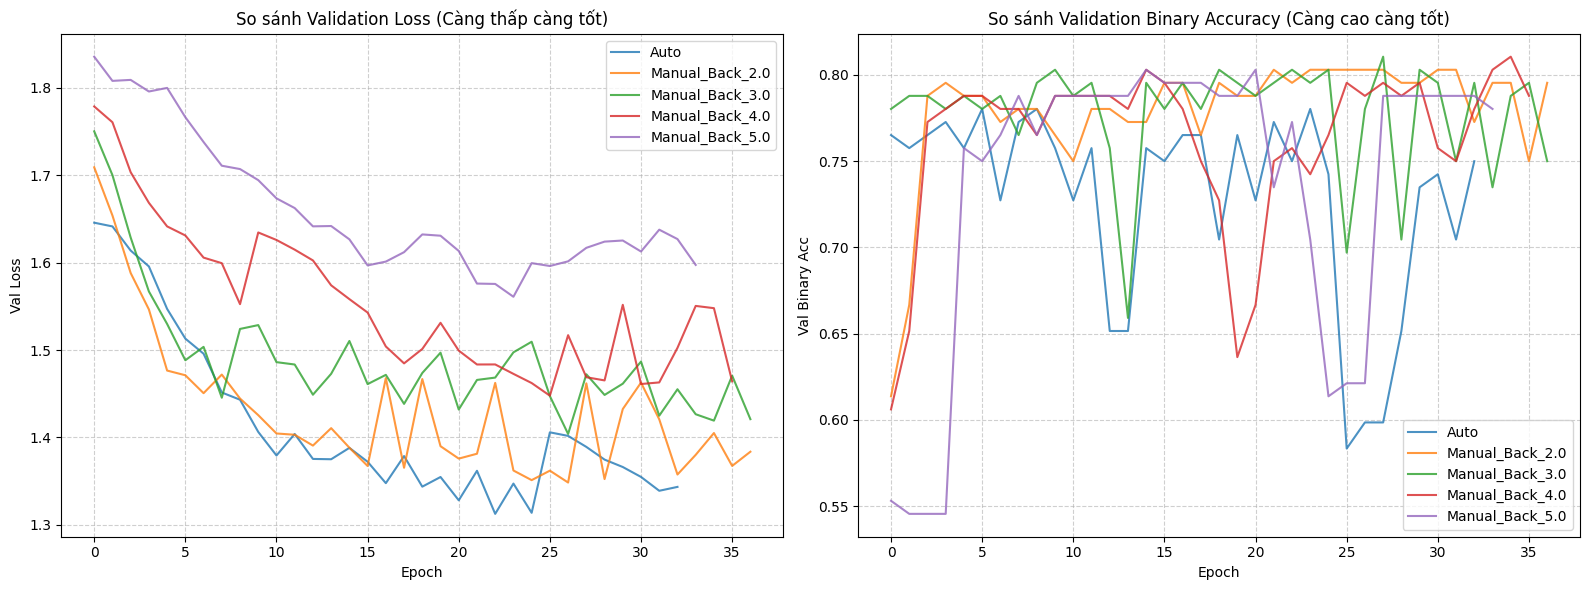


TÓM TẮT KẾT QUẢ (Best val_binary_accuracy
Manual_Back_3.0   : 0.8106
Manual_Back_4.0   : 0.8106
Manual_Back_2.0   : 0.8030
Manual_Back_5.0   : 0.8030
Auto              : 0.7803


In [ ]:
# (THAY THẾ TOÀN BỘ CELL 6 BẰNG CELL NÀY)

if not all_histories:
    print("LỖI: 'all_histories' rỗng. Vui lòng chạy Phần 5 (Vòng lặp Huấn luyện) trước.")
else:
    KEY_NAME = 'val_binary_accuracy' # Metric chính chúng ta theo dõi
    
    plt.figure(figsize=(16, 6)) # Dùng 1 hàng, 2 cột
    
    # --- Biểu đồ 1: So sánh Validation Loss (Hội tụ) ---
    plt.subplot(1, 2, 1)
    for name, history in all_histories.items():
        val_loss_history = history.history.get('val_loss', [])
        if val_loss_history:
            plt.plot(val_loss_history, label=name, alpha=0.8)
    plt.title('So sánh Validation Loss (Càng thấp càng tốt)')
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Biểu đồ 2: So sánh Validation Binary Accuracy ---
    plt.subplot(1, 2, 2)
    for name, history in all_histories.items():
        # Dùng KEY_NAME đã định nghĩa
        val_acc_history = history.history.get(KEY_NAME, [])
        if val_acc_history:
            plt.plot(val_acc_history, label=name, alpha=0.8)
        else:
            print(f"CẢNH BÁO (Biểu đồ 2): Không tìm thấy key '{KEY_NAME}' trong history của '{name}'.")
            
    plt.title('So sánh Validation Binary Accuracy (Càng cao càng tốt)')
    plt.xlabel('Epoch')
    plt.ylabel('Val Binary Acc')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # --- In ra kết quả tóm tắt ---
    print(f"\nTÓM TẮT KẾT QUẢ (Best {KEY_NAME})")
    
    best_scores = {}
    for name, history in all_histories.items():
        val_acc_history = history.history.get(KEY_NAME, [])
        
        if val_acc_history:
            best_score = max(val_acc_history)
        else:
            best_score = 0.0 
        
        best_scores[name] = best_score

    # Sắp xếp để in
    sorted_names = sorted(best_scores, key=best_scores.get, reverse=True)
    for name in sorted_names:
        print(f"{name:<18}: {best_scores[name]:.4f}")